![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [ ]:
# QuantBook Analysis Tool
# For more information see [https://www.quantconnect.com/docs/v2/our-platform/research/getting-started]
qb = QuantBook()
spy = qb.add_equity("SPY")
history = qb.history(qb.securities.keys(), 360, Resolution.DAILY)

# Indicator Analysis
bbdf = qb.indicator(BollingerBands(30, 2), spy.symbol, 360, Resolution.DAILY)
bbdf.drop('standarddeviation', axis=1).plot()

range detection

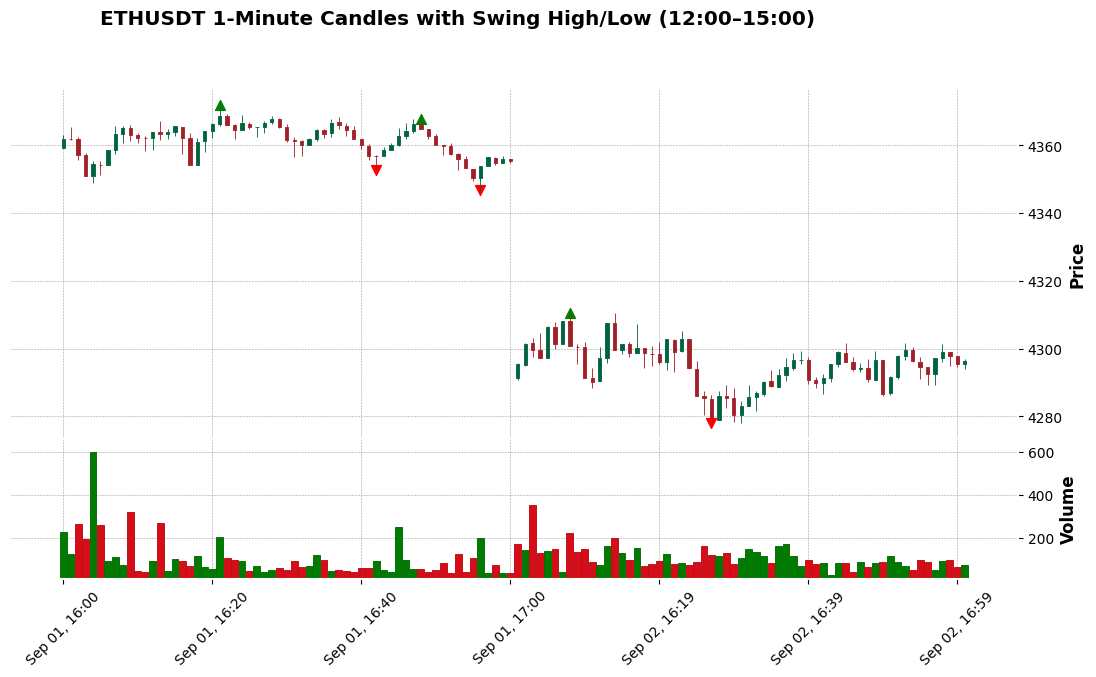

In [9]:
from AlgorithmImports import *
import pandas as pd
import numpy as np
import mplfinance as mpf
from datetime import datetime

qc = QuantBook()

# === Загружаем ETHUSDT с Bybit ===
symbol = qc.AddCrypto("ETHUSDT", Resolution.Minute, Market.Bybit).Symbol

# === История за выбранный диапазон (с 1 по 3 сентября 2025) ===
start_date = datetime(2025, 9, 1)
end_date   = datetime(2025, 9, 3)
history = qc.History([symbol], start_date, end_date, Resolution.Minute)

# === Преобразуем в DataFrame ===
if isinstance(history.index, pd.MultiIndex):
    history = history.reset_index(level=0, drop=True)

ohlc = history[['open', 'high', 'low', 'close', 'volume']].astype(float)
ohlc.index = pd.to_datetime(ohlc.index)

# === Функция swing highs / lows ===
def swing_highs_lows(ohlc: pd.DataFrame, swing_length: int = 50) -> pd.DataFrame:
    swing_length *= 2
    swing_highs_lows = np.where(
        ohlc["high"]
        == ohlc["high"].shift(-(swing_length // 2)).rolling(swing_length).max(),
        1,
        np.where(
            ohlc["low"]
            == ohlc["low"].shift(-(swing_length // 2)).rolling(swing_length).min(),
            -1,
            np.nan,
        ),
    )

    while True:
        positions = np.where(~np.isnan(swing_highs_lows))[0]
        if len(positions) < 2:
            break

        current = swing_highs_lows[positions[:-1]]
        next = swing_highs_lows[positions[1:]]

        highs = ohlc["high"].iloc[positions[:-1]].values
        lows = ohlc["low"].iloc[positions[:-1]].values
        next_highs = ohlc["high"].iloc[positions[1:]].values
        next_lows = ohlc["low"].iloc[positions[1:]].values

        index_to_remove = np.zeros(len(positions), dtype=bool)

        consecutive_highs = (current == 1) & (next == 1)
        index_to_remove[:-1] |= consecutive_highs & (highs < next_highs)
        index_to_remove[1:] |= consecutive_highs & (highs >= next_highs)

        consecutive_lows = (current == -1) & (next == -1)
        index_to_remove[:-1] |= consecutive_lows & (lows > next_lows)
        index_to_remove[1:] |= consecutive_lows & (lows <= next_lows)

        if not index_to_remove.any():
            break

        swing_highs_lows[positions[index_to_remove]] = np.nan

    positions = np.where(~np.isnan(swing_highs_lows))[0]

    if len(positions) > 0:
        if swing_highs_lows[positions[0]] == 1:
            swing_highs_lows[0] = -1
        if swing_highs_lows[positions[0]] == -1:
            swing_highs_lows[0] = 1
        if swing_highs_lows[positions[-1]] == -1:
            swing_highs_lows[-1] = 1
        if swing_highs_lows[positions[-1]] == 1:
            swing_highs_lows[-1] = -1

    level = np.where(
        ~np.isnan(swing_highs_lows),
        np.where(swing_highs_lows == 1, ohlc["high"], ohlc["low"]),
        np.nan,
    )

    return pd.concat(
        [
            pd.Series(swing_highs_lows, index=ohlc.index, name="HighLow"),
            pd.Series(level, index=ohlc.index, name="Level"),
        ],
        axis=1,
    )

# === Применяем функцию ===
swings = swing_highs_lows(ohlc, swing_length=10)

# === Визуализация свечей + Swing High/Low (12:00–15:00) ===
ohlc_workhours = ohlc.between_time('16:00', '17:00')
swings_workhours = swings.loc[ohlc_workhours.index]

swing_high = swings_workhours['Level'].where(swings_workhours['HighLow']==1)
swing_low  = swings_workhours['Level'].where(swings_workhours['HighLow']==-1)

ap = [
    mpf.make_addplot(swing_high, type='scatter', markersize=50, marker='^', color='green'),
    mpf.make_addplot(swing_low, type='scatter', markersize=50, marker='v', color='red')
]

mpf.plot(
    ohlc_workhours,
    type='candle',
    style='charles',
    addplot=ap,
    title="ETHUSDT 1-Minute Candles with Swing High/Low (12:00–15:00)",
    volume=True,
    figsize=(14,7)
)



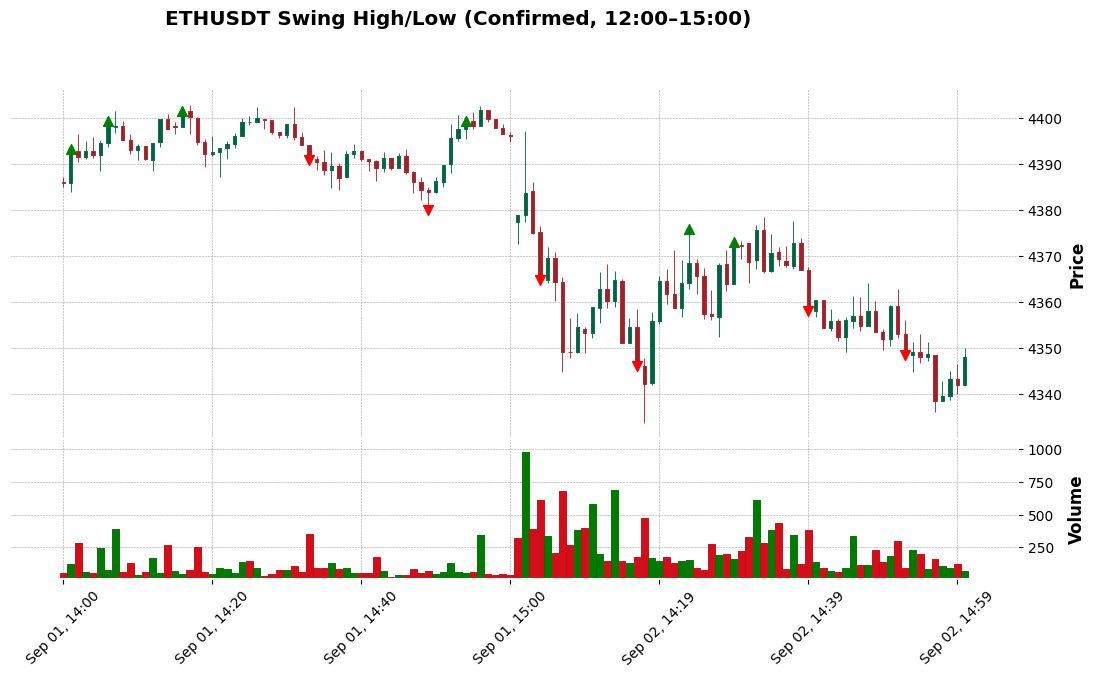

In [2]:
# === Imports ===
from AlgorithmImports import *
from datetime import datetime
import pandas as pd
import numpy as np
import mplfinance as mpf
from collections import deque

# === Инициализация QuantBook ===
qc = QuantBook()
symbol = qc.AddCrypto("ETHUSDT", Resolution.Minute, Market.Bybit).Symbol

# === Загружаем минутные данные с 1 по 3 сентября 2025 ===
start_date = datetime(2025, 9, 1)
end_date   = datetime(2025, 9, 3)
history = qc.History([symbol], start_date, end_date, Resolution.Minute)

# === Преобразуем в DataFrame ===
if isinstance(history.index, pd.MultiIndex):
    history = history.reset_index(level=0, drop=True)

ohlc = history[['open', 'high', 'low', 'close', 'volume']].astype(float)
ohlc.index = pd.to_datetime(ohlc.index)

# === Функция для swing detection (новая версия) ===
def swing_highs_lows_online(
    ohlc: pd.DataFrame,
    N_candidates: list = [5, 10, 20, 50],
    N_confirmation: int = 3,
    min_move_threshold: float = 0.0,
    min_bars_between_swings: int = 3
) -> pd.DataFrame:
    swings = pd.DataFrame(index=ohlc.index, columns=["HighLow", "Level"], dtype=float)
    last_swing_index = -min_bars_between_swings - 1
    
    for N in N_candidates:
        closes = ohlc['close'].values
        highs = ohlc['high'].values
        lows = ohlc['low'].values
        
        future_window = deque(maxlen=N_confirmation)
        
        for i in range(len(ohlc)):
            future_window.append(closes[i])
            if len(future_window) < N_confirmation:
                continue
            
            idx = i - N_confirmation
            if idx < 0 or (idx - last_swing_index) < min_bars_between_swings:
                continue
            
            left = max(0, idx - N)
            right = idx + 1
            candidate_close = closes[idx]
            window_values = closes[left:right]
            
            # Swing High
            if candidate_close == max(window_values):
                if min_move_threshold == 0 or (candidate_close - min(window_values)) / candidate_close >= min_move_threshold:
                    swings.at[ohlc.index[idx], "HighLow"] = 1
                    swings.at[ohlc.index[idx], "Level"] = highs[idx]
                    last_swing_index = idx
            
            # Swing Low
            elif candidate_close == min(window_values):
                if min_move_threshold == 0 or (max(window_values) - candidate_close) / candidate_close >= min_move_threshold:
                    swings.at[ohlc.index[idx], "HighLow"] = -1
                    swings.at[ohlc.index[idx], "Level"] = lows[idx]
                    last_swing_index = idx
                    
    return swings

# === Применяем новую функцию ===
swings = swing_highs_lows_online(
    ohlc,
    N_candidates=[10],          # можно начать с одного окна
    N_confirmation=3,           # подтверждение 3 барами
    min_move_threshold=0.002,   # фильтр по амплитуде (0.2%)
    min_bars_between_swings=5
)

# === Фильтруем диапазон времени для визуализации (12:00–15:00) ===
ohlc_workhours = ohlc.between_time('14:00', '15:00')
swings_workhours = swings.loc[ohlc_workhours.index]

swing_high = swings_workhours['Level'].where(swings_workhours['HighLow']==1)
swing_low  = swings_workhours['Level'].where(swings_workhours['HighLow']==-1)

# === Построение графика ===
ap = [
    mpf.make_addplot(swing_high, type='scatter', markersize=50, marker='^', color='green'),
    mpf.make_addplot(swing_low,  type='scatter', markersize=50, marker='v', color='red')
]

mpf.plot(
    ohlc_workhours,
    type='candle',
    style='charles',
    addplot=ap,
    title="ETHUSDT Swing High/Low (Confirmed, 12:00–15:00)",
    volume=True,
    figsize=(14,7)
)


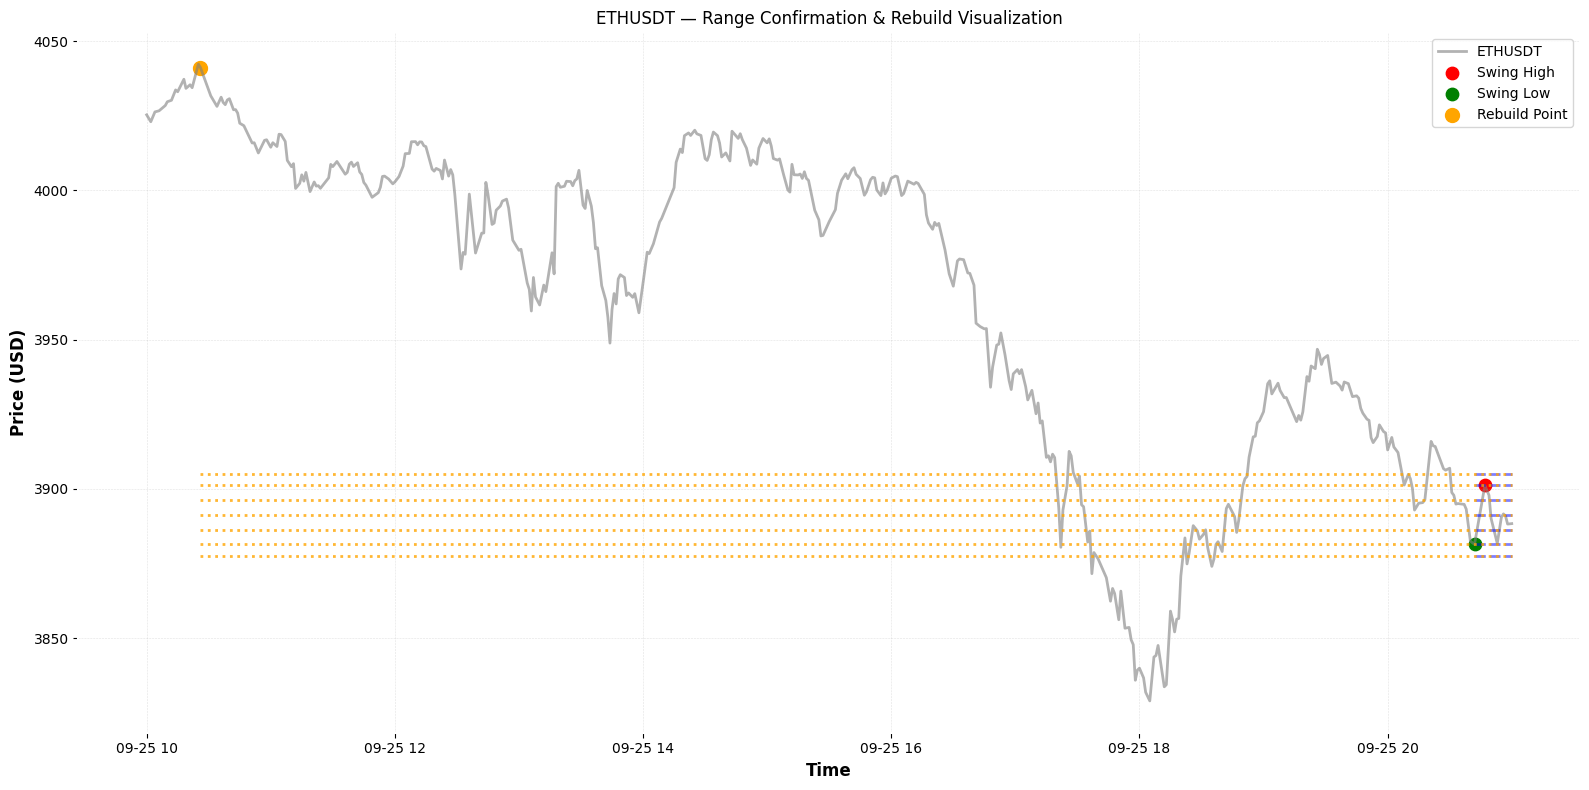

Initial Range → High = 3901.17, Low = 3881.44
Broken = True
Rebuilt at index 20, time = 2025-09-25 10:26:00+00:00


In [15]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Загрузка минутных данных ===
ticker = yf.Ticker("ETH-USD")
df = ticker.history(
    interval="1m",
    start="2025-09-25",
    end="2025-09-26"
)

df = df.between_time("10:00", "21:00").dropna().reset_index()

# === 2. Функция swing high/low ===
def find_swings(df, window=10):
    highs, lows = [], []
    for i in range(window, len(df) - window):
        if df["High"][i] == max(df["High"][i - window:i + window + 1]):
            highs.append(i)
        if df["Low"][i] == min(df["Low"][i - window:i + window + 1]):
            lows.append(i)
    return highs, lows

# === 3. Построение первичного ренджа ===
highs, lows = find_swings(df, window=10)
if len(highs) == 0 or len(lows) == 0:
    raise ValueError("Недостаточно swing high/low для построения диапазона")

last_high_idx = highs[-1]
last_low_idx = lows[-1]

if last_high_idx > last_low_idx:
    high = df["High"][last_high_idx]
    low = df["Low"][last_low_idx]
    direction = "up"
else:
    high = df["High"][last_low_idx]
    low = df["Low"][last_high_idx]
    direction = "down"

ratios = [-0.2, 0.0, 0.25, 0.5, 0.75, 1.0, 1.2]
diff = high - low
levels = {r: low + diff * r for r in ratios}

last_range = {"high": high, "low": low, "levels": levels, "direction": direction}

# === 4. Проверка разрушения / перестроения ренджа ===
def update_fib_range(df, last_range, direction, lookback=20):
    high = last_range["high"]
    low = last_range["low"]
    levels = last_range["levels"]

    for i in range(lookback, len(df)):
        close = df["Close"].iloc[i]

        # Разрушение
        if close > levels[1.2] or close < levels[-0.2]:
            return last_range, i, True

        # Проверка возврата в зону
        if direction == "up":
            if close < levels[0.75]:
                # ждём возврат выше
                for j in range(i, min(i + lookback, len(df))):
                    if df["Close"].iloc[j] >= levels[0.75]:
                        window_df = df.iloc[i:j+1]
                        new_high = window_df["High"].max()
                        new_high_idx = window_df["High"].idxmax()
                        diff = new_high - low
                        new_levels = {r: low + diff * r for r in [-0.2, 0.0, 0.25, 0.5, 0.75, 1.0, 1.2]}
                        new_range = {
                            "low": low, "high": new_high, "levels": new_levels, "direction": "up"
                        }
                        return new_range, new_high_idx, False

        elif direction == "down":
            if close > levels[0.25]:
                # ждём возврат ниже
                for j in range(i, min(i + lookback, len(df))):
                    if df["Close"].iloc[j] <= levels[0.25]:
                        window_df = df.iloc[i:j+1]
                        new_low = window_df["Low"].min()
                        new_low_idx = window_df["Low"].idxmin()
                        diff = high - new_low
                        new_levels = {r: high - diff * (1 - r) for r in [-0.2, 0.0, 0.25, 0.5, 0.75, 1.0, 1.2]}
                        new_range = {
                            "low": new_low, "high": high, "levels": new_levels, "direction": "down"
                        }
                        return new_range, new_low_idx, False

    return last_range, None, False


updated_range, rebuild_idx, broken = update_fib_range(df, last_range, direction)

# === 5. Визуализация ===
plt.figure(figsize=(16, 8))
plt.plot(df["Datetime"], df["Close"], label="ETHUSDT", color="gray", alpha=0.6)

# Swing-точки
plt.scatter(df["Datetime"][last_high_idx], df["High"][last_high_idx], color="red", s=80, label="Swing High")
plt.scatter(df["Datetime"][last_low_idx], df["Low"][last_low_idx], color="green", s=80, label="Swing Low")

# Старый рендж
for r, level in last_range["levels"].items():
    plt.hlines(level,
               xmin=df["Datetime"].iloc[min(last_high_idx, last_low_idx)],
               xmax=df["Datetime"].iloc[-1],
               colors="blue", linestyles="dashed", alpha=0.5)

# Новый рендж (если есть перестроение)
if rebuild_idx:
    for r, level in updated_range["levels"].items():
        plt.hlines(level,
                   xmin=df["Datetime"].iloc[rebuild_idx],
                   xmax=df["Datetime"].iloc[-1],
                   colors="orange", linestyles="dotted", alpha=0.8)
    plt.scatter(df["Datetime"].iloc[rebuild_idx], df["Close"].iloc[rebuild_idx],
                color="orange", s=100, label="Rebuild Point")

plt.title("ETHUSDT — Range Confirmation & Rebuild Visualization")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial Range → High = {high:.2f}, Low = {low:.2f}")
print(f"Broken = {broken}")
if rebuild_idx:
    print(f"Rebuilt at index {rebuild_idx}, time = {df['Datetime'].iloc[rebuild_idx]}")


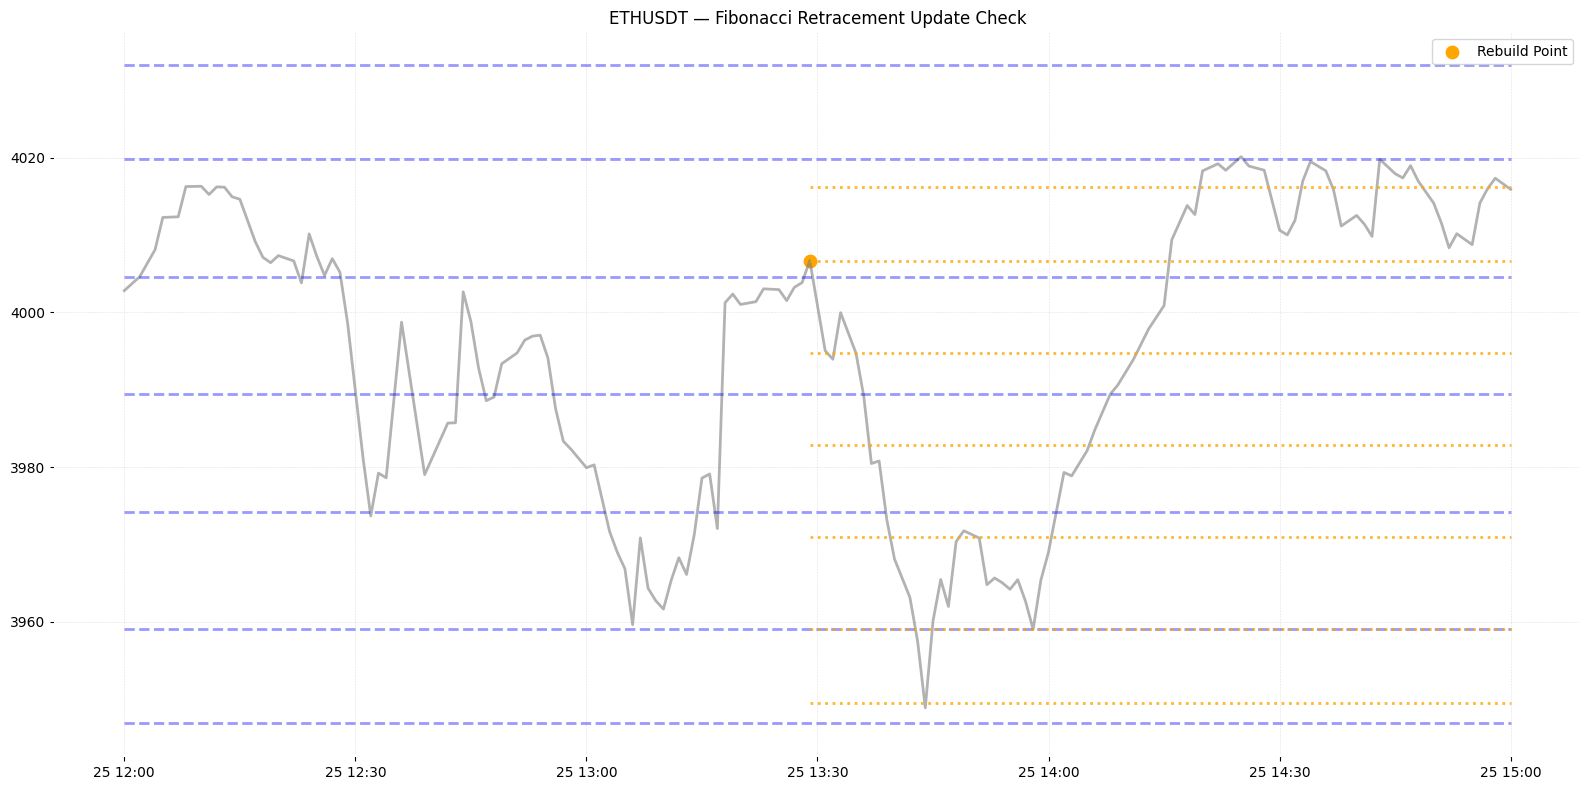

Broken: False
Rebuilt at: 76


In [11]:
def update_fib_range(df, last_range, direction, lookback=20):
    high = last_range["high"]
    low = last_range["low"]
    levels = last_range["levels"]

    # --- 1. Порог разрушения ---
    for i in range(lookback, len(df)):
        close = df["Close"].iloc[i]

        # Разрушение диапазона
        if close > levels[1.2] or close < levels[-0.2]:
            return last_range, i, True

        # --- 2. Проверка возврата в зону 0.75–1.0 / 0–0.25 ---
        if direction == "up":
            # Цена уходит ниже 0.75 и возвращается выше
            if close < levels[0.75]:
                # Ждём возврат
                for j in range(i, min(i + lookback, len(df))):
                    if df["Close"].iloc[j] >= levels[0.75]:
                        # нашли возврат в зону
                        window_df = df.iloc[i:j+1]
                        # Новый локальный high
                        new_high = window_df["High"].max()
                        new_high_idx = window_df["High"].idxmax()

                        # Перестраиваем уровни
                        diff = new_high - low
                        new_levels = {r: low + diff * r for r in [-0.2, 0.0, 0.25, 0.5, 0.75, 1.0, 1.2]}
                        new_range = {
                            "low": low,
                            "high": new_high,
                            "levels": new_levels,
                            "direction": "up"
                        }
                        return new_range, new_high_idx, False

        elif direction == "down":
            # Цена уходит выше 0.25 и возвращается ниже
            if close > levels[0.25]:
                for j in range(i, min(i + lookback, len(df))):
                    if df["Close"].iloc[j] <= levels[0.25]:
                        window_df = df.iloc[i:j+1]
                        new_low = window_df["Low"].min()
                        new_low_idx = window_df["Low"].idxmin()

                        diff = high - new_low
                        new_levels = {r: high - diff * (1 - r) for r in [-0.2, 0.0, 0.25, 0.5, 0.75, 1.0, 1.2]}
                        new_range = {
                            "low": new_low,
                            "high": high,
                            "levels": new_levels,
                            "direction": "down"
                        }
                        return new_range, new_low_idx, False

    # Если ничего не изменилось
    return last_range, None, False

    # === 8. Проверка обновления диапазона ===
last_range = {
    "low": low,
    "high": high,
    "levels": levels,
    "direction": "up" if last_high_idx > last_low_idx else "down"
}

updated_range, rebuild_idx, broken = update_fib_range(df, last_range, last_range["direction"])

plt.figure(figsize=(16, 8))
plt.plot(df["Datetime"], df["Close"], color="gray", alpha=0.6)
plt.title("ETHUSDT — Fibonacci Retracement Update Check")

# Рисуем старый диапазон
for r, level in last_range["levels"].items():
    plt.hlines(level, xmin=df["Datetime"].iloc[0], xmax=df["Datetime"].iloc[-1], colors="blue", linestyles="dashed", alpha=0.4)

# Если обновился — показываем новый
if rebuild_idx:
    for r, level in updated_range["levels"].items():
        plt.hlines(level, xmin=df["Datetime"].iloc[rebuild_idx], xmax=df["Datetime"].iloc[-1], colors="orange", linestyles="dotted", alpha=0.8)
    plt.scatter(df["Datetime"].iloc[rebuild_idx], df["Close"].iloc[rebuild_idx], color="orange", s=80, label="Rebuild Point")

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Broken:", broken)
print("Rebuilt at:", rebuild_idx)

